In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sn
import matplotlib.pyplot as plt

In [55]:
# Choose the path of the data
X_data_path = "data/X_data_10sec.csv"
y_data_path = "data/y_data_10sec.csv"

In [56]:
# Set the parameters
epochs = 16
seconds = "10sec" # length of each sample, this will be used only to name the files with the results

In [57]:
X_data = np.loadtxt(X_data_path, delimiter=",")
X_data.shape

(3000, 38400)

In [58]:
X_data

array([[  0.28048742,   0.81629163,  -6.23892689, ..., -47.85346985,
        -47.85346985, -38.20292664],
       [ -4.82241058,  -6.21592712, -10.80950546, ..., -46.43103409,
        -46.43103409, -46.43103409],
       [  3.79986668,   5.4657836 ,   5.81849146, ..., -49.15478134,
        -49.15478134, -33.45807266],
       ...,
       [-21.03319359, -24.26096344, -23.05108261, ..., -60.63187408,
        -60.63187408, -42.44838333],
       [ -7.60533762, -11.47871494, -10.9920063 , ..., -61.26615906,
        -61.26615906, -43.74389267],
       [ -8.89348984, -21.42334938, -28.44589043, ..., -59.62312698,
        -59.62312698, -44.60402679]])

In [59]:
y_data = np.loadtxt(y_data_path, dtype=str)
y_data.shape

(3000,)

In [60]:
y_data

array(['blues', 'blues', 'blues', ..., 'rock', 'rock', 'rock'],
      dtype='<U9')

In [61]:
labels = np.unique(y_data)
labels

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [62]:
y_data2 = np.zeros((y_data.shape[0], len(labels)))

for i, label in enumerate(labels):
    for j in range(y_data.shape[0]):
        if y_data[j] == label:
            y_data2[j][i] = 1
            
y_data2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [63]:
X_data2 = X_data.reshape(X_data.shape[0], 128, 300, 1)
X_data2.shape

(3000, 128, 300, 1)

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 128, 300, 1)
(600, 128, 300, 1)
(2400, 10)
(600, 10)


In [65]:
# def conv_block(x, n_filters=64,filter_size=(7, 128), pool_size=(2, 2),stride=(2, 2)):
#     x = keras.layers.Conv2D(n_filters, filter_size, activation = "relu", strides=(1, 1), padding='same')(x)
#     x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=stride)(x)
#     x = keras.layers.Dropout(0.5)(x)
#     return x
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = keras.layers.Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = keras.layers.Dropout(0.4)(x)
    return x

In [66]:
nn_input = keras.Input(shape=(128,300,1))
x = conv_block(nn_input, 16,stride=(2,2))
x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 64, stride=(2,2))
x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 256,stride=(2,2))
x = keras.layers.Reshape((4,2304), input_shape=(4,9,256))(x)
x = keras.layers.GRU(1024, activation="relu", return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(len(labels), 
                        activation='softmax')(x)
    
model = keras.Model(inputs=nn_input, outputs=predictions)

In [67]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 300, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 300, 16)      160       
                                                                 
 activation_10 (Activation)  (None, 128, 300, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 150, 16)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 64, 150, 16)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 150, 32)       4640      
                                                           

In [68]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [69]:
history = model.fit(
      X_train,
      y_train,
      epochs=epochs, 
      batch_size=64,
      validation_split=0.10
        )

Epoch 1/16
34/34 [==============================] - 84s 2s/step - loss: 3.8928 - accuracy: 0.1019 - val_loss: 2.3015 - val_accuracy: 0.1375
Epoch 2/16
34/34 [==============================] - 76s 2s/step - loss: 2.2381 - accuracy: 0.1458 - val_loss: 2.2939 - val_accuracy: 0.1542
Epoch 3/16
34/34 [==============================] - 76s 2s/step - loss: 2.1249 - accuracy: 0.2190 - val_loss: 2.2880 - val_accuracy: 0.1125
Epoch 4/16
34/34 [==============================] - 76s 2s/step - loss: 2.0914 - accuracy: 0.2259 - val_loss: 2.2821 - val_accuracy: 0.1208
Epoch 5/16
34/34 [==============================] - 76s 2s/step - loss: 2.0060 - accuracy: 0.2708 - val_loss: 2.2890 - val_accuracy: 0.1500
Epoch 6/16
34/34 [==============================] - 75s 2s/step - loss: 1.8999 - accuracy: 0.3042 - val_loss: 2.2697 - val_accuracy: 0.2208
Epoch 7/16
34/34 [==============================] - 76s 2s/step - loss: 1.8556 - accuracy: 0.3185 - val_loss: 2.2562 - val_accuracy: 0.1958
Epoch 8/16
34/34 [==

In [70]:
model.save("models/GRU_model_" + seconds + "_" + str(epochs) + "epochs")

INFO:tensorflow:Assets written to: models/GRU_model_10sec_16epochs\assets


INFO:tensorflow:Assets written to: models/GRU_model_10sec_16epochs\assets


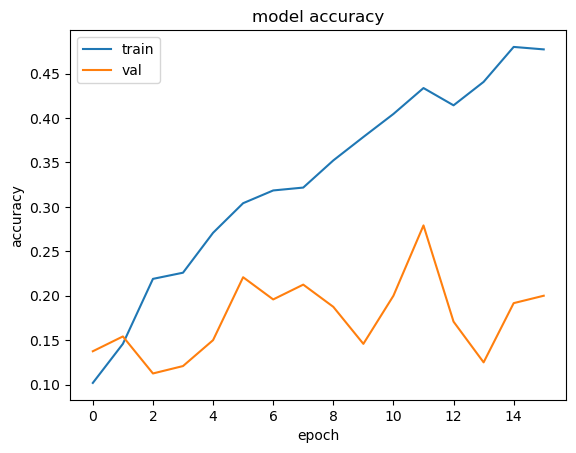

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/GRU_accuracy_" + seconds + ".png")
plt.show()

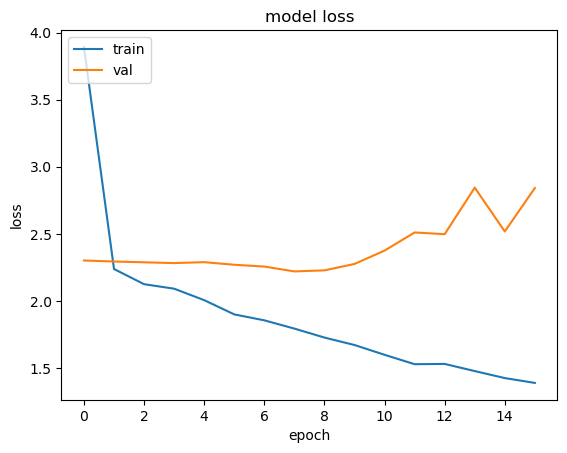

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/GRU_loss_" + seconds + ".png")
plt.show()

In [73]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 3.098 and val_acc = 0.170


In [74]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred

19/19 [==============================] - 5s 251ms/step
(600, 10)


array([[2.3535218e-05, 2.0046816e-06, 1.2852765e-04, ..., 1.8724871e-03,
        2.2051939e-04, 3.9928374e-03],
       [8.9808004e-03, 3.1504824e-03, 3.9683901e-02, ..., 2.6560469e-02,
        6.4813215e-03, 2.4184671e-01],
       [3.7251555e-03, 1.2285021e-03, 1.4770530e-02, ..., 3.7727565e-01,
        2.9358890e-02, 7.1455032e-02],
       ...,
       [1.4937374e-02, 6.3586328e-03, 5.0431106e-02, ..., 7.2435841e-02,
        1.9128103e-02, 2.0171613e-01],
       [2.4378622e-02, 9.7546019e-03, 8.2640901e-02, ..., 3.0650502e-02,
        9.0686977e-03, 3.7501100e-01],
       [1.0968114e-02, 5.3168372e-03, 7.9242766e-02, ..., 4.9916994e-02,
        5.7047703e-03, 4.8719463e-01]], dtype=float32)

In [75]:
y_classes = y_pred.argmax(1)
y_classes[:15]

array([6, 6, 7, 9, 6, 6, 4, 6, 4, 6, 9, 9, 4, 7, 6], dtype=int64)

In [76]:
y_test2 = y_test.argmax(1)
y_test2[:15]

array([8, 0, 3, 5, 4, 1, 8, 0, 8, 7, 2, 9, 7, 8, 4], dtype=int64)

In [77]:
import sklearn.metrics as mt

accuracy = mt.accuracy_score(y_test2, y_classes)
precision = mt.precision_score(y_test2, y_classes, average = "macro")
recall = mt.recall_score(y_test2, y_classes, average = "macro")
f1_score = mt.f1_score(y_test2, y_classes, average = "macro")
print("accuracy     : " + str(accuracy))
print("precision    : " + str(precision))
print("recall       : " + str(recall))
print("f1-score     : " + str(f1_score))

accuracy     : 0.17
precision    : 0.11446353461182006
recall       : 0.20647305320037684
f1-score     : 0.12002182030202153


C:\Users\Utente\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# model_metrics = {
#     "epochs" : [64],
#     "accuracy" : [accuracy],
#     "precision" : [precision],
#     "recall" : [recall],
#     "f1-score" : [f1_score]
# }
# df_metrics = pd.DataFrame(model_metrics)
# metrics_path = "metrics/GRU_metrics_" + seconds + ".csv"
# df_metrics.to_csv(metrics_path, index=False)

In [79]:
metrics_path = "metrics/GRU_metrics_" + seconds + ".csv"
df_metrics = pd.read_csv(metrics_path)
df_metrics

,epochs,accuracy,precision,recall,f1-score
0,32.0,0.346667,0.446165,0.359516,0.286792
1,64.0,0.476667,0.628770,0.470385,0.434655


In [80]:
model_metrics = {
    "epochs" : epochs,
    "accuracy" : accuracy,
    "precision" : precision,
    "recall" : recall,
    "f1-score" : f1_score
}
df_metrics = df_metrics.append(model_metrics, ignore_index=True)
df_metrics = df_metrics.sort_values(["epochs"])
df_metrics

C:\Users\Utente\AppData\Local\Temp\ipykernel_11852\2179813385.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(model_metrics, ignore_index=True)


,epochs,accuracy,precision,recall,f1-score
2,16.0,0.170000,0.114464,0.206473,0.120022
0,32.0,0.346667,0.446165,0.359516,0.286792
1,64.0,0.476667,0.628770,0.470385,0.434655


In [81]:
df_metrics.to_csv(metrics_path, index=False)

In [82]:
cm = mt.confusion_matrix(y_test2, y_classes)
print(cm)

[[ 0  0  0  0  0  0 59  0  0 11]
 [ 0  0  0  0  0  0 27  0  0 43]
 [ 0  0  0  0  0  0 27  0  0 31]
 [ 0  0  0  0  4  0 38  5  0 15]
 [ 0  0  0  0 22  0 34  1  0  0]
 [ 0  0  0  0  0  0 32  0  0 38]
 [ 0  0  0  0  0  0 44  0  0  1]
 [ 0  0  0  0 17  0  8 17  0  5]
 [ 0  0  0  0 23  0 36  3  0  3]
 [ 0  0  0  0  0  0 33  4  0 19]]


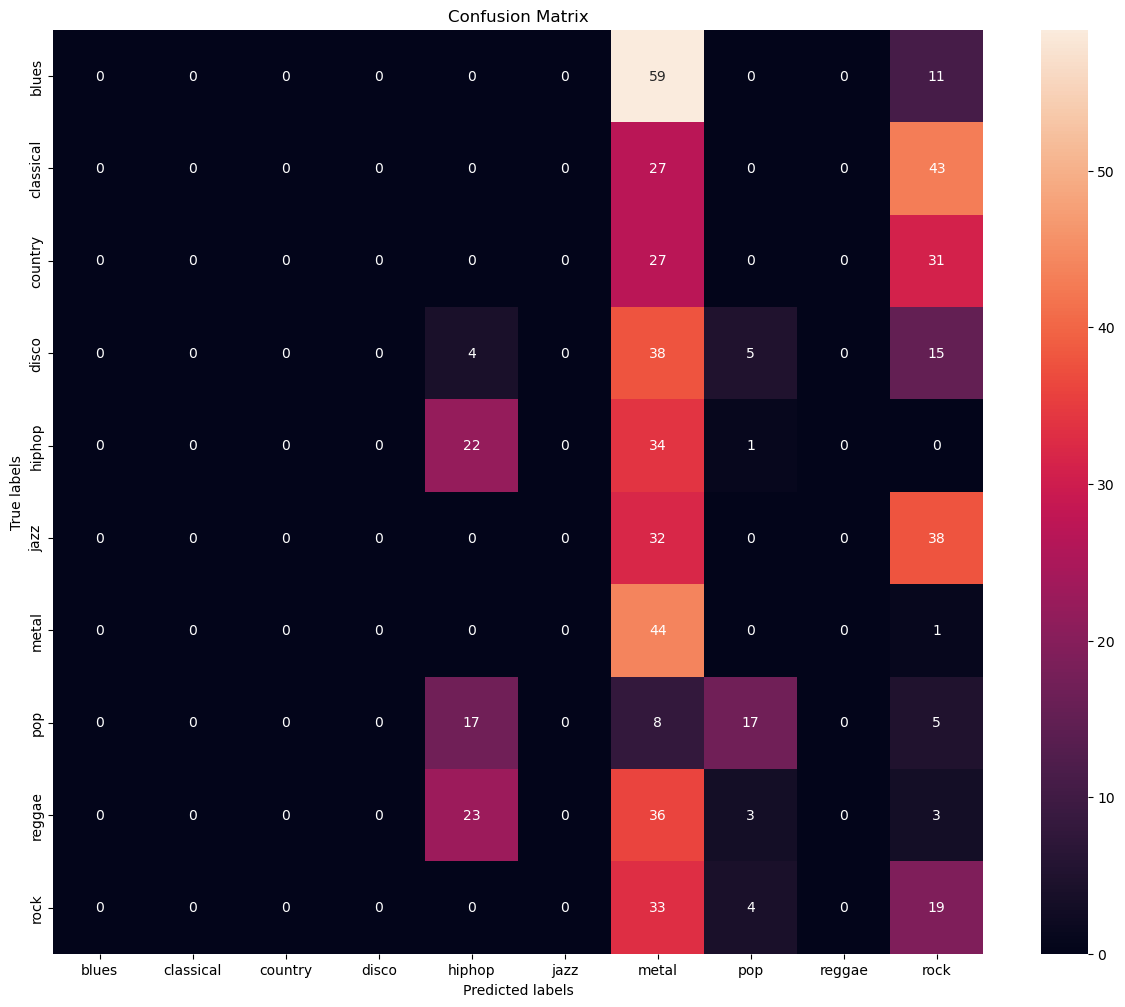

In [83]:
plt.figure(figsize=(15,12))
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.savefig("images/" + seconds + "/GRU_confusion_matrix_" + str(epochs) + "epochs.png")